# Numerical *simulation* of the OU stochastic process

Let's consider an Ornstein-Uhlenbeck (OU) process $x(t)$, whose (steady-state) mean and variance are $\mu$ and  $\sigma^2$, respectively. It is defined by the following stochastic differential equation:

$$\tau \frac{dx}{dt} = \mu-x + \sigma \sqrt{2 \tau} \xi(t)$$

Abusing the notation of ordinary differential equations, $\xi(t)$ is a *Gaussian white-noise* characterised by zero mean, unitary variance, and Dirac's Delta autocorrelation, with Gaussian probability density distribution as follows:

$< \xi(t) > = 0 \ \ \ \ \ < \xi(t)\xi(t+T) > = \delta(T)\ \ \ \ \ \ p_\xi(Z) = (\sqrt{2\pi})^{-1} e^{-Z^2/2}$.

$x(t)$ is then a Gauss-distributed non-stationary process, fully characterised by its time-varying mean $m_x(t)$, variance $s(t)$ and autocovariance. The probability density distribution is then $p_x(X) = (\sqrt{2\pi s(t)^2})^{-1} e^{-(X-m(t))^2/(2 s(t)^2)}$, with

$$ m(t)\ =\ <x(t)>\ =\ x_0 e^{-(t-t_0)/\tau} +  \mu  \left( 1 - e^{-(t-t_0)/\tau}\right) \longrightarrow \mu $$

$$s(t)^2\ =\ <\left[x(t) - m(t)\right]^2>\ =\ \sigma^2   \left(1 - e^{-2(t-t_0)/\tau}\right)  \longrightarrow \sigma^2$$

where x0 indicates the (deterministic) initial condition of x(t) at time $t_0$, and the autocovariance

$$Cov_x(t, T)\ =\ < \left[x(t) - m(t)\right] \left[x(t+T) - m(t+T)\right]>\ =\ \sigma^2 e^{-|T|/\tau}  (1 - e^{-2(t-t_0)/\tau}) )  \longrightarrow \sigma^2 e^{-|T|/\tau} $$

Numerically simulating the continuous-time process $x(t)$ requires iterating the following expression

$$y(t + \Delta t) \approx \left( 1 -\Delta t/\tau \right)\ y(t) +   \mu \Delta t/\tau + \sigma \sqrt{2 \Delta t/\tau }\  \hat{\xi}$$

where the (integration) time step $\Delta t$ must be *small enough*, and where at every iteration $\hat{\xi}$ is generated as a new realisation of a pseudo-random zero mean, unitary variance, uncorrelated Gauss-distributed number:

$$< \hat{\xi} > = 0 \ \ \ \ \ < \hat{\xi}_k\hat{\xi}_{m} > = \delta_{k\ m}\ \ \ \ \ \ p_{\hat{\xi}}(Z) = (\sqrt{2\pi})^{-1} e^{-Z^2/2}$$

with $\delta_{k\ m}$ being the Kronecker's delta.

However, an alternative exact update rule is also available (Gillespie, 1992) that is valid for any finite value of $\Delta t$:

$$y(t+\Delta t) = e^{-\Delta t/\tau}\ y(t) +   \mu \left(1 - e^{-\Delta t/\tau}\right) + \sigma \sqrt{1 - e^{- 2\Delta t /\tau}}\  \hat{\xi}$$

It is easy to prove that, in the limit of small $\Delta t$, such an exact update rule reduces to the approximate expression above. 

In Julia, one can easily generate a realisation of this OU process, containing $N$ points, by three different style of code:

In [1]:
# Let's first define the numerical parameters of our numerical example

μ  = 50.;      # Steady-state mean of x(t)
σ  = 6.;       # Steady-state standard deviation of x(t)
τ  = 2.;       # Relaxation time [ms]

x0 = 0.;       # (Deterministic) initial condition

Δt = 0.02;     # Discretization time interval [ms]

N  = 10000000; # No. of samples to generate (beware of transients if x0 is nonzero!);

In [2]:
# Let's preallocate the memory for three vectors, which will be used for the three methods

x1    = zeros(Float64, N);   # Let's preallocate the memory for x1 - note this is a 1-D vector
x2    = zeros(Float64, N);   # Let's preallocate the memory for x2 - note this is a 1-D vector
x3    = zeros(Float64, N);   # Let's preallocate the memory for x3 - note this is a 1-D vector;

The first method does not exploit the true potential of Julia for numerical computation, as no *function* is defined.

In [3]:
# The first method (slowest) is based on common-sense scripting

srand(359);    # Set a (fixed) random number seed - for reproducibility purpouses

tmp1 = exp(-Δt/τ);                # Useful constant to slighlty reduce the n. of operations
tmp2 = σ * sqrt(1-exp(-2*Δt/τ));  # Useful constant to slighlty reduce the n. of operations
tmp3 = μ * (1 - exp(-Δt/τ));      # Useful constant to slighlty reduce the n. of operations

x1[1] = x0;                       # We take care of the initial condition

@time for i=2:N,
    x1[i] = x1[i-1] * tmp1 + tmp3 + tmp2 * randn(); # exact iterative rule (Gillespie's)
end

  5.985887 seconds (110.00 M allocations: 1.937 GB, 4.92% gc time)


The second method defines a function, calls it with *minimal size* to have it compiled, and then fires it up with full-sized problem.

In [4]:
# The second method (~30-50 times fastester) is based on Julia's just-in-time compilation skills

# We first define a function, which changes one of its input argument (for efficiency)
function simulate_ou!(x, N, x0, Δt, μ, σ, τ)
    tmp1 = exp(-Δt/τ);                # Useful to slighlty reduce the n. of operations
    tmp2 = σ * sqrt(1-exp(-2*Δt/τ));  # Useful to slighlty reduce the n. of operations
    tmp3 = μ * (1 - exp(-Δt/τ));      # Useful to slighlty reduce the n. of operations

    x[1] = x0;                        # We take care of the initial condition
    for i=2:N,
        x[i] = x[i-1] * tmp1 + tmp3 + tmp2 * randn();
    end
end

# We call the function once, with N = 2, so that it is compiled once for all
simulate_ou!(x2, 2, x0, Δt, μ, σ, τ);

# We then run the real call to generate N samples
srand(359);    # Set a (fixed) random number seed - for reproducibility purpouses

@time simulate_ou!(x2, N, x0, Δt, μ, σ, τ);

  0.108288 seconds (66 allocations: 35.594 KB)


The third method is the vectorised version of the first and employs the function *filt()*. It consumes more memory and it is slower.

In [5]:
# The third method (slightly slower) is based on Julia's own DSP and filtering capabilities

srand(359);    # Set a (fixed) random number seed - for reproducibility purpouses

tmp1 = exp(-Δt/τ);                  # Useful to slighlty reduce the n. of operations
tmp2 = σ * sqrt(1. - exp(-2*Δt/τ)); # Useful to slighlty reduce the n. of operations
tmp3 = μ * (1. - exp(-Δt/τ));       # Useful to slighlty reduce the n. of operations

b  = [0, 1];          # Refer to the documentation of "filt!()" - these are coefficients
a  = [1, -tmp1];      # to efficiently compute a discrete-time iterative equation.

@time filt!(x3, b, a, tmp3 + tmp2 * randn(N), [x0]); 

  0.473860 seconds (146.12 k allocations: 235.885 MB, 5.88% gc time)


By virtue of the fixed random number seed initialisation, produces exactly the same sequence of numerical values, as confirmed below (apart from very minor rounding errors).

The mean square error comparing x1 and x2 is 0.0
The mean square error comparing x1 and x3 is 1.7638370652718947e-9
The mean square error comparing x2 and x3 is 1.7638370652718947e-9


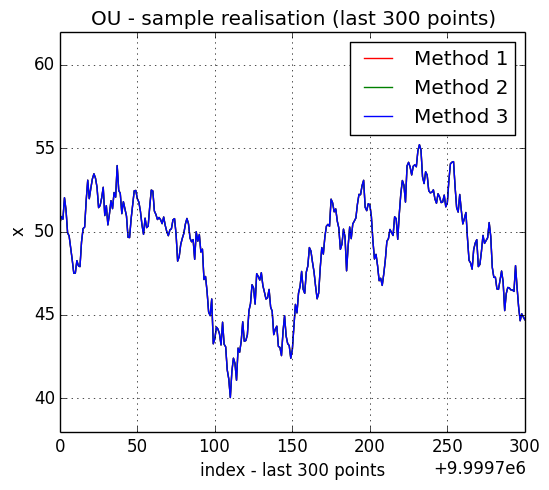

In [6]:
# Let's see whether the numerical sequences are identical (result should be ~zero)

test1 = 1./N * sqrt(sum(x1.*x1 - x2.*x2));
test2 = 1./N * sqrt(sum(x1.*x1 - x3.*x3));
test3 = 1./N * sqrt(sum(x2.*x2 - x3.*x3));

println("The mean square error comparing x1 and x2 is $test1");
println("The mean square error comparing x1 and x3 is $test2");
println("The mean square error comparing x2 and x3 is $test3");

using PyPlot
fig = figure("Sample realisation",figsize=(6,5)); # Create a new figure, with desired size

index = (N-300):N;
plot(index, x1[index], "r", label="Method 1");
plot(index, x2[index], "g", label="Method 2");
plot(index, x3[index], "b", label="Method 3");

ax = gca()                                     # Get a "handle" on the current axes
ax[:set_ylim]((μ-2*σ),(μ+2*σ)); 

xlabel("index - last 300 points");# Label of the horizontal axis
ylabel("x");                                   # Label of the vertical axis
title("OU - sample realisation (last 300 points)"); # Label of the title, at the top of the figure
grid("on");                                    # "Grid" on

legend(borderaxespad=0.5);                     # Add a legend to the current axes;


We now analyse (one of) the generated time series, checking for consistency of its statistical properties against the theory. Bear in mind that the larger $N$, the more accurate will be the agreement between simulation and theory (i.e. large numbers theorem). We first evaluate mean, variance, and then we estimate the probability density function (i.e. by means of the normalised histogram) and compare it to the theoretical Gaussian curve.

In [7]:
# Let's use x2, since x1, x2, and x3 are identical
# Note that one should discard a transient because the theoretical PDF is non-stationary.
# However, if x0 is zero the transient should only affect the estimate of the variance.
transient    = Int64(floor(10. * τ / Δt) + 1);
x            = x2[transient:end];
N            = length(x)
println("Mean is $(mean(x)) [theoretical $μ]");
println("Stdev is $(std(x)) [theoretical $(σ)]");

Mean is 49.969602453770236 [theoretical 50.0]
Stdev is 6.014366270070594 [theoretical 6.0]


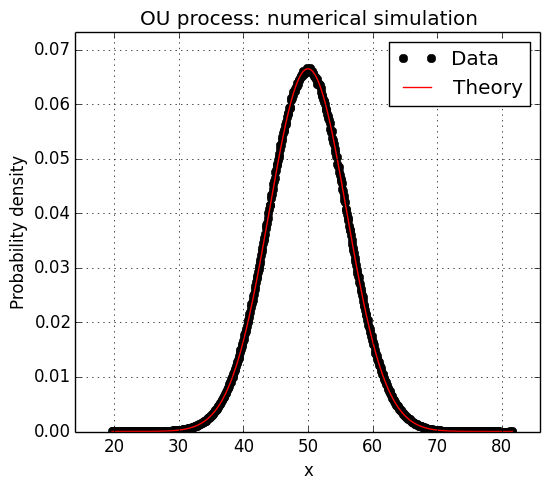

In [8]:
# Let's now estimate the probability density function (pdf), through the histogram

fig = figure("Probability density function",figsize=(6,5)); # Create a new figure, with desired size

Npts         = 1000; 
(edges, counts) = hist(x, Npts);              # Compute the histogram of x1 over Npts points
xx           = midpoints(edges);              # Midpoints of the bins with edges "edges"

ΔE           = edges[3] - edges[2];           # Do not use edges[1] as it is an exception
pdf          = counts / (N * ΔE);             # Normalization, so it becomes a PDF

pdf_theory= (1. / sqrt(2 * π * σ^2)) * exp(-(xx-μ).*(xx-μ)/(2 * σ^2)); # A Gaussian pdf!;

plot(xx, pdf, "ko", label="Data");            # Plot in the current figure
plot(xx, pdf_theory, "r", label="Theory");    #, LineWidth="2");  

ax = gca()                                    # Get a "handle" on the current axes
ax[:set_xlim]((μ-6*σ),(μ+6*σ));               # For axes "ax" set the horizontal limits
ax[:set_ylim]((0,1.1*maximum(pdf)));       # For axes "ax" set the vertical limits

xlabel("x");                                   # Label of the horizontal axis
ylabel("Probability density");                 # Label of the vertical axis
title("OU process: numerical simulation");     # Label of the title, at the top of the figure
grid("on");                                    # "Grid" on

legend(borderaxespad=0.5);                     # Add a legend to the current axes;

We finally compute the autocorrelation (i.e. the covariance of the process upon removing the *offset*, being the square mean).

In [9]:
# Let's finally estimate the autocorrelation function (i.e. autocovariance without the offset)

fig = figure("OU - autocorrelation",figsize=(6,5));    # Create a new figure, with desired size;

# Let's remove the mean from x, prior to compute the correlation
xc   = xcorr(x - mean(x), x - mean(x)); # xcorr is like the corresponding MATLAB command;
lags = 1.0 * collect((-N+1):(N-1));     # The vector containing the "lags" is defined (w/o Δt);

normalised_xc = xc ./ (N-abs(lags));                 # Unbiased normalisation
xc_theory     = σ^2*exp(-abs(lags*Δt)/(τ));          # Theoretical autocorrelation;

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x335e75390>)

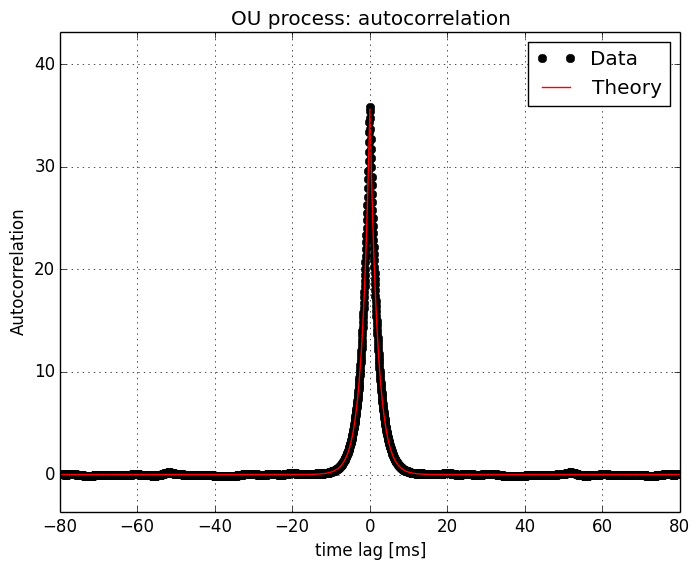

In [101]:
M             = 3;                             # For reducing the points to plot
plot(Δt*lags[1:M:end], normalised_xc[1:M:end], "ko", label="Data");  # Plot in the current figure,
plot(Δt*lags[1:M:end], xc_theory[1:M:end], "r", label="Theory");#, LineWidth="2"); 

ax = gca()                                    # Get a "handle" on the current axes
ax[:set_xlim](-40*τ,40*τ);                      # For axes "ax" set the horizontal limits
ax[:set_ylim]((-.1*σ^2, 1.2*σ^2));             # For axes "ax" set the vertical limits

xlabel("time lag [ms]");                       # Label of the horizontal axis
ylabel("Autocorrelation");                     # Label of the vertical axis
title("OU process: autocorrelation");          # Label of the title, at the top of the figure
grid("on");                                    # "Grid" on

legend(borderaxespad=0.5);                     # Add a legend to the current axes;